In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rfpimp

import utils
from data_statistical_features import Segment, SegmentStatistical
import eda_utils

import os

plt.rcParams.update(utils.get_plt_settings())

save=True

/Users/zianor/.virtualenvs/venv/Bachelorarbeit/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


# Load Data

In [3]:
df = pd.read_csv(utils.get_own_features_csv_path(segment_length=10, overlap_amount=0.9, hr_threshold=10,
                                                 data_folder='data_patients'), index_col=False)
features = df.drop(Segment.get_feature_name_array(), axis='columns')
informative_inf = df[Segment.get_feature_name_array()]

df.columns = [col.replace("_", " ") for col in df.columns]
features.columns = [col.replace("_", " ") for col in features.columns]
informative_inf.columns = [col.replace("_", " ") for col in informative_inf.columns]

target = df['informative']
patient_id = df['patient id']

from ml_statistical_features import get_patient_split
x_train, x_test, y_train, y_test, groups_train, groups_test = get_patient_split(features, target, patient_id, test_size=0.33)
x_train = x_train.dropna()
x_test = x_test.dropna()
y_train = y_train.loc[x_train.index]
y_test = y_test.loc[x_test.index]

In [4]:
features.columns

Index(['mean', 'std', 'number zero crossings', 'kurtosis', 'skewness',
       'hf ratio acf', 'hf ratio data', 'hf diff acf', 'hf diff data',
       'abs energy', 'interval lengths std', 'interval lengths range',
       'sqi std', 'sqi min', 'sqi max', 'sqi median', 'sqi mean', 'peak mean',
       'peak std', 'template corr highest sqi mean',
       'template corr highest sqi std', 'template corr median sqi mean',
       'template corr median sqi std', 'interval means std',
       'interval stds std', 'interval ranges std', 'sqi coverage 03',
       'sqi coverage 04', 'sqi coverage 05', 'peak range'],
      dtype='object')

In [5]:
latex_names = {
    'error': '$E\\textsubscript{HR}$',
    'hf ratio data': '$\\texttt{ratio}\\textsubscript{data}$',
    'hf ratio acf': '$\\texttt{ratio}\\textsubscript{acf}$',
    'hf diff acf': '$\\texttt{diff}\\textsubscript{acf}$',
    'hf diff data': '$\\texttt{diff}\\textsubscript{data}$',
    'abs energy': '$E\\textsubscript{abs}$',
    'interval lengths mean': '$\\text{IL}\\textsubscript{mean}$',
    'interval lengths std': '$\\text{IL}\\textsubscript{std}$',
    'interval lengths range': '$\\text{IL}\\textsubscript{range}$',
    'sqi mean': '$\\text{SQI}\\textsubscript{mean}$',
    'sqi median': '$\\text{SQI}\\textsubscript{median}$',
    'sqi min': '$\\text{SQI}\\textsubscript{min}$',
    'sqi std': '$\\text{SQI}\\textsubscript{std}$',
    'sqi max': '$\\text{SQI}\\textsubscript{max}$',
    'peak range': '$\\text{P}\\textsubscript{range}$',
    'peak mean': '$\\text{P}\\textsubscript{mean}$',
    'peak std': '$\\text{P}\\textsubscript{std}$',
    'template corr highest sqi mean': '$\\texttt{mean}\\textsubscript{T\\textsubscript{SQI}}$',
    'template corr highest sqi std': '$\\texttt{std}\\textsubscript{T\\textsubscript{SQI}}$',
    'template corr median sqi mean':'$\\texttt{mean}\\textsubscript{T\\textsubscript{median}}$',
    'template corr median sqi std': '$\\texttt{std}\\textsubscript{T\\textsubscript{median}}$',
    'interval means std': '$\\texttt{mean}\\textsubscript{std}$', 
    'interval stds std': '$\\texttt{std}\\textsubscript{std}$',
    'interval ranges std': '$\\texttt{range}\\textsubscript{std}$',
    'sqi coverage 03': '$C_{0{,}3}$',
    'sqi coverage 04': '$C_{0{,}4}$',
    'sqi coverage 05': '$C_{0{,}5}$'
}

# Parallel Coordinates

Index(['mean', 'number zero crossings', 'kurtosis', 'skewness',
       '$\texttt{diff}\textsubscript{acf}$',
       '$\texttt{diff}\textsubscript{data}$', '$\text{IL}\textsubscript{std}$',
       '$\text{SQI}\textsubscript{std}$', '$\text{SQI}\textsubscript{min}$',
       '$\text{SQI}\textsubscript{median}$', '$\text{P}\textsubscript{mean}$',
       '$\text{P}\textsubscript{std}$',
       '$\texttt{mean}\textsubscript{T\textsubscript{SQI}}$',
       '$\texttt{std}\textsubscript{T\textsubscript{SQI}}$',
       '$\texttt{mean}\textsubscript{T\textsubscript{median}}$',
       '$\texttt{std}\textsubscript{T\textsubscript{median}}$',
       '$\texttt{mean}\textsubscript{std}$', '$C_{0{,}3}$', '$C_{0{,}4}$',
       '$C_{0{,}5}$'],
      dtype='object')


KeyboardInterrupt: 

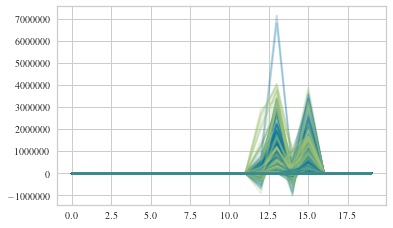

In [9]:
from yellowbrick.features import ParallelCoordinates

pc_x = x_train.loc[:, remaining_cols]
pc_x.rename(columns=latex_names, inplace=True)
print(pc_x.columns)

fig, ax = plt.subplots(figsize=utils.get_plt_big_size())
pc = ParallelCoordinates(classes=["informativ", "nicht informativ"], features=pc_x.columns)
pc.fit(pc_x, y_test)
pc.transform(pc)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
pc.poof()


In [ ]:
cols = ['peak max','peak min', 'peak mean', 'error', 'informative']
sns.pairplot(df.loc[x_train.index, cols], kind='scatter', hue='informative', dropna=True)

# Feature Transformation

In [10]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler

from ml_statistical_features import get_patient_split


In [11]:
std_scaler = StandardScaler()

x1, x2, y1, y2, groups1, groups2 = get_patient_split(features, target, patient_id, test_size=0.33)

mask = x2.dropna().index
y2 = y2.loc[mask]


x2 = x2.loc[mask, ('mean', 'number zero crossings', 'kurtosis', 'skewness', 'hf diff acf', 'hf diff data',
                  'interval lengths std', 'sqi std', 'sqi min', 'sqi median',
                  'peak mean', 'peak std', 'template corr highest sqi mean', 'template corr highest sqi std',
                  'template corr median sqi mean', 'template corr median sqi std','interval means std',
                  'sqi coverage 03', 'sqi coverage 04', 'sqi coverage 05')]

x_std = std_scaler.fit_transform(x2.dropna())

<Figure size 425.205x425.205 with 0 Axes>

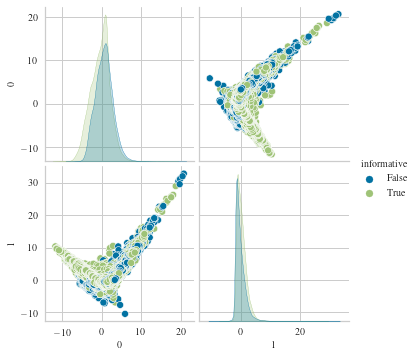

In [12]:

pca = PCA(n_components=2)
x_transform = pca.fit_transform(x_std)
df = pd.DataFrame(x_transform)
df['informative'] = y2.values

<Figure size 148.822x148.822 with 0 Axes>

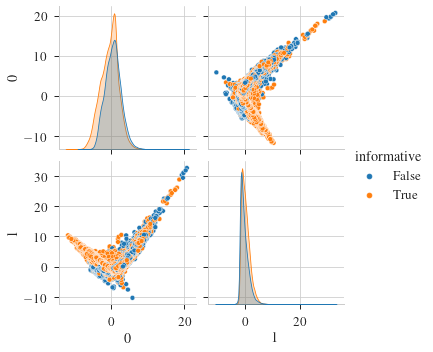

In [19]:
sns.set_context("paper", font_scale=1.5) 
width, _ = utils.get_plt_normal_size()
plt.figure(figsize=(width/2, width/2))

sns.pairplot(df, kind='scatter', hue='informative', palette="tab10")

if save:
    plt.savefig(os.path.join(utils.get_thesis_pic_path(),'pca-own-reduced.pdf'), bbox_inches='tight',
                transparent=True, dpi=300)

# Mutual Information

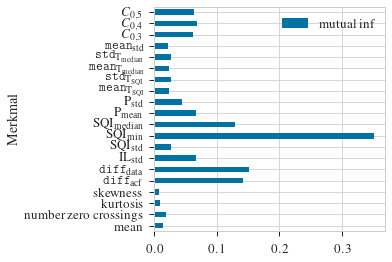

In [24]:
from sklearn import feature_selection

mask = x2.dropna().index
y2 = y2.loc[mask]

width, _ = utils.get_plt_normal_size()

mic = feature_selection.mutual_info_classif(x2, y2)
x2.rename(columns=latex_names, inplace=True)
fig, ax = plt.subplots(figsize=(width,width))

pd.DataFrame({"Merkmal": x2.columns, "mutual inf": mic}).set_index("Merkmal").plot.barh(ax=ax)

if save:
    plt.savefig(os.path.join(utils.get_thesis_pic_path(),'mutual-inf-own.pdf'), bbox_inches='tight',
                transparent=True, dpi=300)